# AIMs Positions, Populations and MAFs

## General settings and loading of files

In [129]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

%run helpers/data_munging_functions.py
%run helpers/number_helpers.py
%run general_settings.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[10:18:46] 'panels' dict
[10:18:46] 'galanter', 'present', 'missing' dataframes
[10:18:46] 'panel_labels'
[10:18:46] 'panel_names' dict
[10:18:46] 'panel_rsIDs' dict
[10:18:46] 'genome' dataframe
[10:18:54] 'lat' dataframe
[10:19:08] 'control_genotypes' huge datagrame
[10:19:08] 'control_rsIDs' dict to filter it ^
[10:19:08] 'cp_factors' list
[10:19:08] 'control_labels'
[10:19:08] 'control_names' dict
[10:19:08] 'df_1000G_samples'
[10:19:08] 'df_1000G_SNPs'
[10:19:08] 'df_1000G_genotypes'
[10:19:08] 'df_1000G_populations'
[10:19:09] 'df_1000G_genotypes_alleles'

/home/juan/repos/tesina/panels/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1588: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())



[10:19:09] 'mafs' dataframe


/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1590: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


## Compare the panels

In [114]:
from panels.panel_analyser import PanelAnalyser


analyser = PanelAnalyser()
count_comparison = analyser.compare_panel_lengths({**panels, **control_rsIDs})
ancestry_comparison = analyser.compare_AIMs_ancestry(panels)
lsbl_comparison = analyser.compare_LSBL(panels)

print("== Counts\n")
print(count_comparison)
print()

print("== Counts per ancestry\n")
print(ancestry_comparison)
print()

print("== LSBL cumsum per ancestry\n")
print(lsbl_comparison)


== Counts

             AIMs count  Ratio
Panel                         
GAL_Completo        445   1.00
GAL_Affy            180   0.40
CPx100           43,144  96.95
CPx10             4,424   9.94
CPx1                438   0.98

== Counts per ancestry

    GAL_Completo                    GAL_Affy                 
      AIMs count Panel Percentage AIMs count Panel Percentage
AFR          114              26%         62              34%
EUR          202              45%         71              39%
NAM          129              29%         47              26%

== LSBL cumsum per ancestry

           GAL_Completo           GAL_Affy         
              LSBL(Fst) LSBL(In) LSBL(Fst) LSBL(In)
population                                         
AFR                72.4     43.5      39.6     23.7
EUR                77.9     44.0      28.3     15.9
NAM                74.5     44.0      27.0     16.0


En GAL_Affy observamos un aumento de la proporción de AIMs africanos respecto de los europeos, mientras que la proporción de AIMs americanos sigue igual. Esto podría tener por consecuencia, a primera vista, una sobreestimación del componente africano al usar GAL_Affy. No obstante, debe calcularse el LSBL acumulado de los SNPs de cada grupo y comparar *ese* valor.

Los AIMs que quedan en GAL_Affy siguen balanceados en cuanto a LSBL para determinar los componentes EUR y NAM. EL valor de LSBL queda relativamente más alto que en GAL_Completo, por lo que debemos estar atentos a posibles diferencias en resultado entre GAL_Affy y GAL_Completo que afecten específicamente al componente ancestral africano --en particular, que lo sobreestimen.

Sin embargo, esto no parece ser un problema en nuestros resultados, al menos para las muestras de 1000 Genomas utilizadas. La comparación de proporción de ancestría africana estimada para las diferentes poblaciones parece mantenerse igual entre ambos paneles, a pesar de esa reducción diferencial de AIMs. Con todo, este _caveat_ quedará para futuros usos de GAL_Affy.

/home/juan/repos/tesina/panels/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]


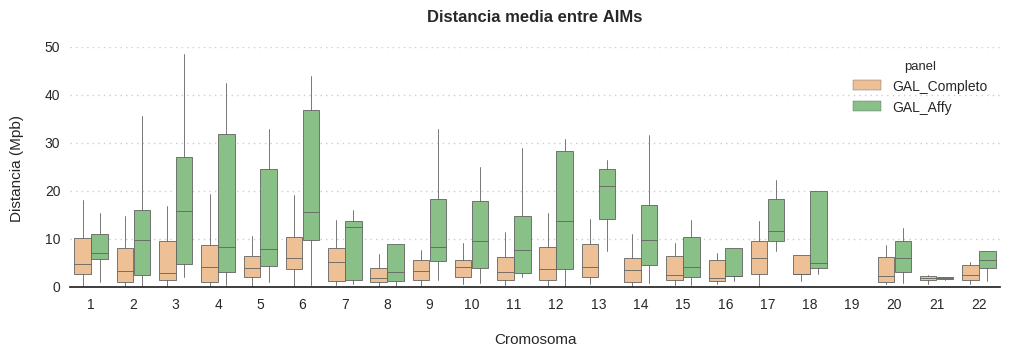

In [229]:
from plotters.snp_distances import SnpDistances


SnpDistances().snp_distances_comparison_boxplot()

## Comparar Galanter de PLoS / dbSNP / ...

In [5]:
# galanter_remapped = pd.read_csv("/home/juan/tesina/files/galanter.GRCh38.p6.bed", sep="\t",
#                                names=['chr', 'position', 'pos_to', 'id'], comment="#", skiprows=3,
#                                usecols=['chr', 'position', 'pos_to', 'id'])

# # The online remapping generated weird chromosomes
# weird_chromosomes = galanter_remapped["chr"].str.contains("_")
# galanter_remapped.drop(galanter_remapped[weird_chromosomes].index, inplace=True)

# galanter_remapped['chr'] = galanter_remapped['chr'].str.replace("chr", "").astype(int)
# galanter_remapped.drop_duplicates("id", keep="last", inplace=True)
# galanter_remapped.set_index('id', inplace=True)

# galanter_plos = galanter[['chr', 'position']]

# import re

# galanter_dbSNP = pd.read_csv("/home/juan/tesina/files/galanter_rsIDs_dbSNP",
#                              names=['id', 'source', 'chr', 'pos', 'pos_to'], skiprows=1).set_index('id')
# take_these_out = galanter_dbSNP.chr.str.contains('HSCHR')
# galanter_dbSNP = galanter_dbSNP[~take_these_out]
# galanter_dbSNP['chr'] = galanter_dbSNP['chr'].astype(int)
# galanter_dbSNP = galanter_dbSNP.drop_duplicates()

# galanter.index.difference(galanter_remapped.index)

# print(galanter.index.difference(galanter_remapped.index))
# print(galanter_remapped.index.difference(galanter.index))

Debería usar las posiciones de el build `GRCh38.p6` en `galanter_remapped`, pero no están todas puede ser? Chequear

## Generate CONTROL PANELS of random SNPs

- Extract the **same amount * factor** of SNPs per chromosome as Galanter has,
  with some min space between them.
- The SNPs to extract should all be present in LAT-1


The script to generate the SNPs lists is `./scripts/generate_control_panels.py`

With the generated SNP lists per chromosome, we need to extract those variants
from the 1000 Genomes `*.vcf` files, using PLINK.

The script for this is `/home/juan/tesina/1000 ... /create_control_panels.sh`

In [118]:
# # I think this is not needed anymore:
# galanter.groupby("chr").size().to_csv("data/chr_SNP_count_in_galanter")

## Plot the distribution of AIMs per chromosome

* Chromosome lengths were taken from:

[Assembly Statistics for GRCh38.p6 Release date: December 23, 2015](http://www.ncbi.nlm.nih.gov/projects/genome/assembly/grc/human/data/)

* Centromere ranges were taken from the FTP server: 

ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA_000001405.21_GRCh38.p6/GCA_000001405.21_GRCh38.p6_assembly_structure/genomic_regions_definitions.txt

El archivo `galanter.bed` con las posiciones de los AIMs reportadas por Galanter *et al.* correspondía al genoma de referencia `GRCh37.p5`. La conversión al build `GRCh38.p6` fue realizada online con la herramienta de *remapping* provista por NCBI Genome Tools, de modo que fueran coherentes con la información sobre longitud total de los cromosomas y rango de los centrómeros.

http://www.ncbi.nlm.nih.gov/genome/tools/remap

In [14]:
# galanter["pos"] = galanter_remapped["position"]

/home/juan/repos/tesina/panels/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


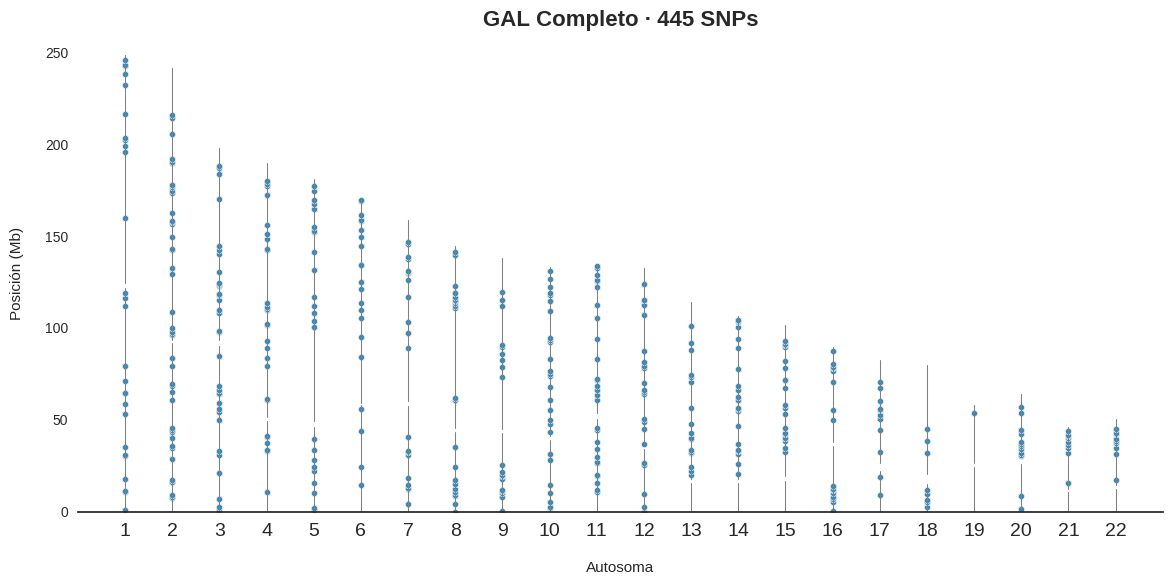

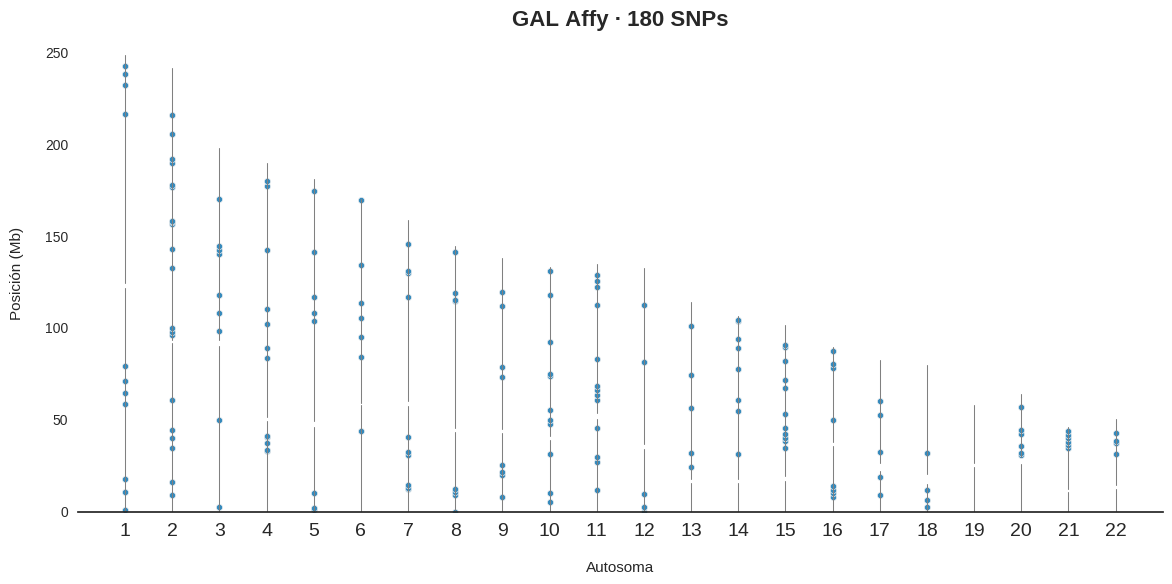

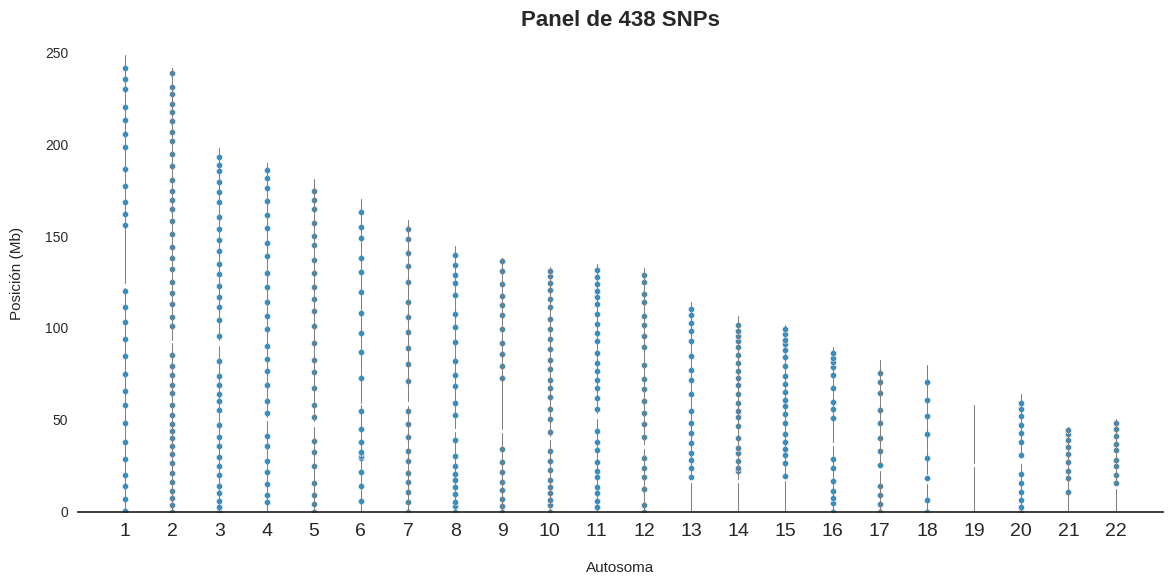

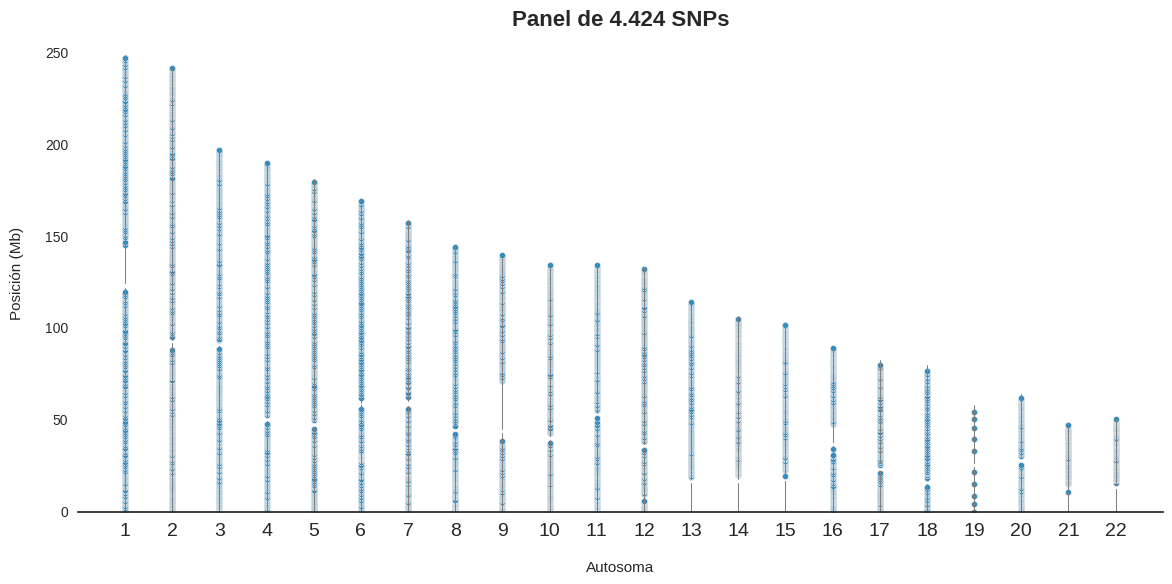

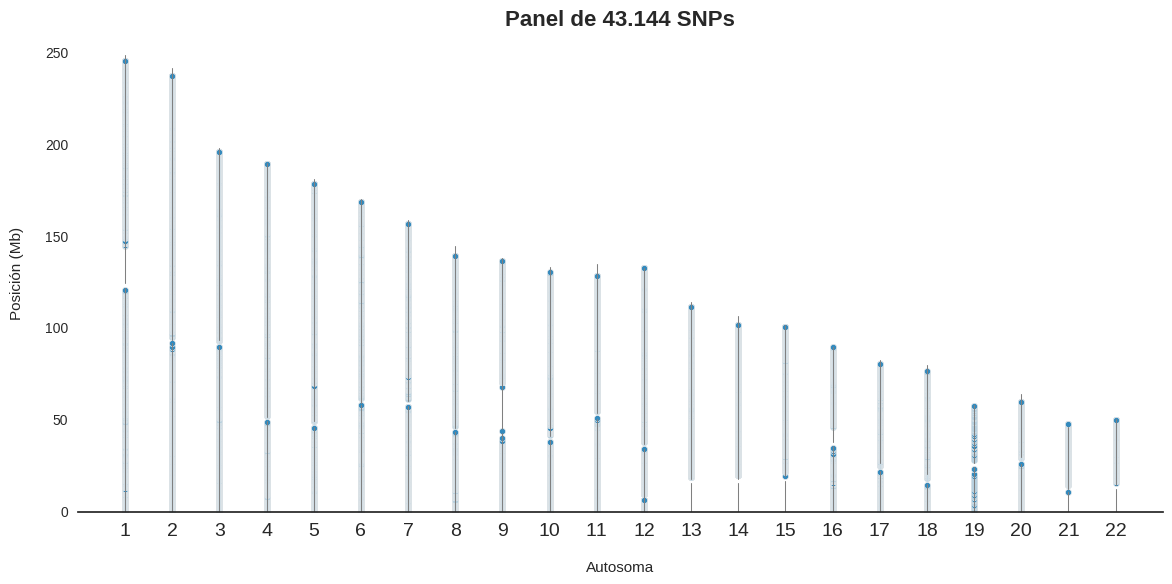

In [247]:
import seaborn as sns

from plotters.snp_distances import SnpDistances

sns.set_context("notebook")
sns.set_style("white")

control_positions = OrderedDict()
for label, rsIDs in control_rsIDs.items():
    df = lat.loc[rsIDs][["Chromosome", "Position End"]]
    df.columns = ["chr", "position"]
    df["position"] = df["position"].astype(int)
    df["chr"] = df["chr"].astype(int)
    df.index.name = "rsID"
    df.name = label
    control_positions[label] = df

plotter = SnpDistances()
for panels_dic in [panels, control_positions]:
    for panel_label, panel in panels_dic.items():
        plotter.chromosomes_with_SNPs_plot(panel)
        plt.show()

## Descarga de data de 1000Genomes

In [20]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [21]:
# % run extract_SNPs_from_vcf_chromosomes.py

# commands = extract_SNPs_from_vcf(galanter.index.values)

# ^ One time only run, to extract the SNPs out of the big files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

## Compute MAF by Population (1000 Genomes data)

I use both `plink` and `pandas` for this computation. `pandas` to make the `.fam` files
with either population or subpopulation names in the family field. `plink` to
compute the frequencies using each of the `.fam` files.

In [248]:
# # This is used to generate different .fam files (with population and superpopulation data)
# # so that plink can generate frequencies relative to those groups.

# basedir = "/home/juan/tesina/1000Genomes_data/galanter_beds/"
# fam_file_fields = ["fam", "sample", "father", "mother", "sex", "phenotype"]

# for panel_name in panel_labels:

#     # Read original .fam with no populations info
#     fn = basedir + "{}.fam".format(panel_name)
#     nofam = pd.read_csv(fn, engine="python", sep="\s*", names=fam_file_fields,
#                         index_col="sample")

#     # Write the populations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_samples["population"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.populations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

#     # Write the superpopulations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_samples["super_population"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.superpopulations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

After the previous cell (`.fam` files generation), plink was run to compute the frequencies per population and generate the `.frq.strat` files.

Check the bash script `/home/juan/tesina/1000Genomes_data/galanter_beds/2_compute_freqs.sh`

In [249]:
print("1000 Genomas:", len(df_1000G_SNPs))
print("Galanter panel:", len(galanter))

1000 Genomas: 442
Galanter panel: 445


**NOTA** sobre los SNPs que faltan: en el proceso de leer la data de 1000 genomas estoy dejando afuera tres SNPs, porque tienen más de 2 variantes.

In [250]:
missing_in_1000g = set(galanter.index) - set(df_1000G_SNPs.index)
galanter.loc[missing_in_1000g]

,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In)
SNP rsID,,,,,,,,,,
rs2242865,21,15948902,G,T,0.011,0.156,0.932,AFR,0.695,0.422
rs2510719,11,126511001,A,C,0.034,0.574,0.039,EUR,0.341,0.196
rs12065716,1,116575568,G,C,0.389,0.885,0.136,EUR,0.372,0.207
rs10071261,5,1066694,T,C,0.107,0.086,0.903,AFR,0.650,0.375


## Comparar los MAFs por población y panel

In [254]:
def minidescribe(df):
    df = df.join(mafs["population"]["GAL_Completo"]).loc[:, "ACB":"YRI"]
    df = df.describe().loc[["mean", "std"]].T
    df = df.applymap(lambda x: round(x, 2))
    df["mean ± std"] = df["mean"].astype(str) + " ± " + df["std"].astype(str)
    return df

galanter_summary = minidescribe(galanter)
present_summary = minidescribe(present)

# This uses Galanter-provided MAFs!
maf_mean_comparison = galanter_summary.join(present_summary, rsuffix="_")
maf_mean_comparison["Difference"] = abs(maf_mean_comparison["mean"] - maf_mean_comparison["mean_"])
maf_mean_comparison.drop(["mean", "std", "mean_", "std_"], axis=1, inplace=True)
maf_mean_comparison.columns = ["GAL_Completo", "GAL_Affy", "Difference"]

print("Comparación usando los MAFs provistos **por 1000 Genomas**")
maf_mean_comparison

Comparación usando los MAFs provistos **por 1000 Genomas**


,GAL_Completo,GAL_Affy,Difference
ACB,0.17 ± 0.1,0.18 ± 0.1,0.01
ASW,0.23 ± 0.1,0.25 ± 0.1,0.02
BEB,0.31 ± 0.12,0.28 ± 0.13,0.03
CDX,0.27 ± 0.14,0.26 ± 0.15,0.01
CEU,0.22 ± 0.12,0.2 ± 0.12,0.02
CHB,0.27 ± 0.14,0.26 ± 0.15,0.01
CHS,0.27 ± 0.14,0.26 ± 0.15,0.01
CLM,0.34 ± 0.11,0.32 ± 0.12,0.02
ESN,0.11 ± 0.1,0.11 ± 0.09,0.00
FIN,0.24 ± 0.13,0.21 ± 0.13,0.03


^ Entre ambos paneles no hay ninguna población cuyos MAFs (promediados para todos los AIMs!) cambien demasiado. Es un comienzo.

/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1588: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1590: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


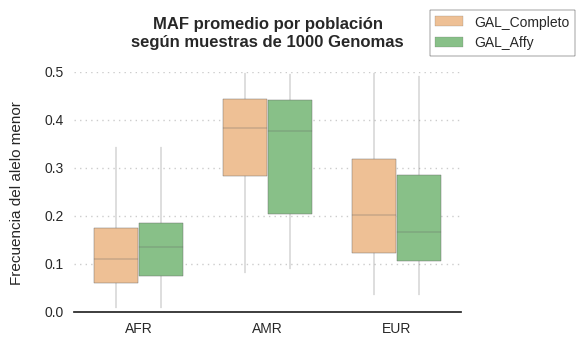

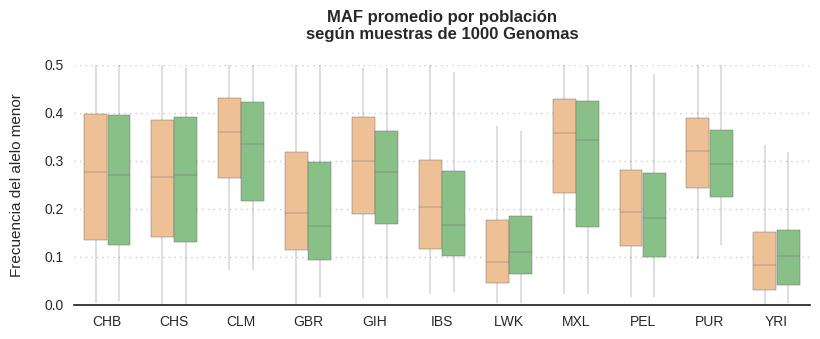

In [408]:
from plotters.maf import MAFPlotter


MAFPlotter().MAF_comparison_boxplot()

^ Should mean continental MAFs be similar between 1000 Genomes samples and the ones in Galanter csv? They are not.

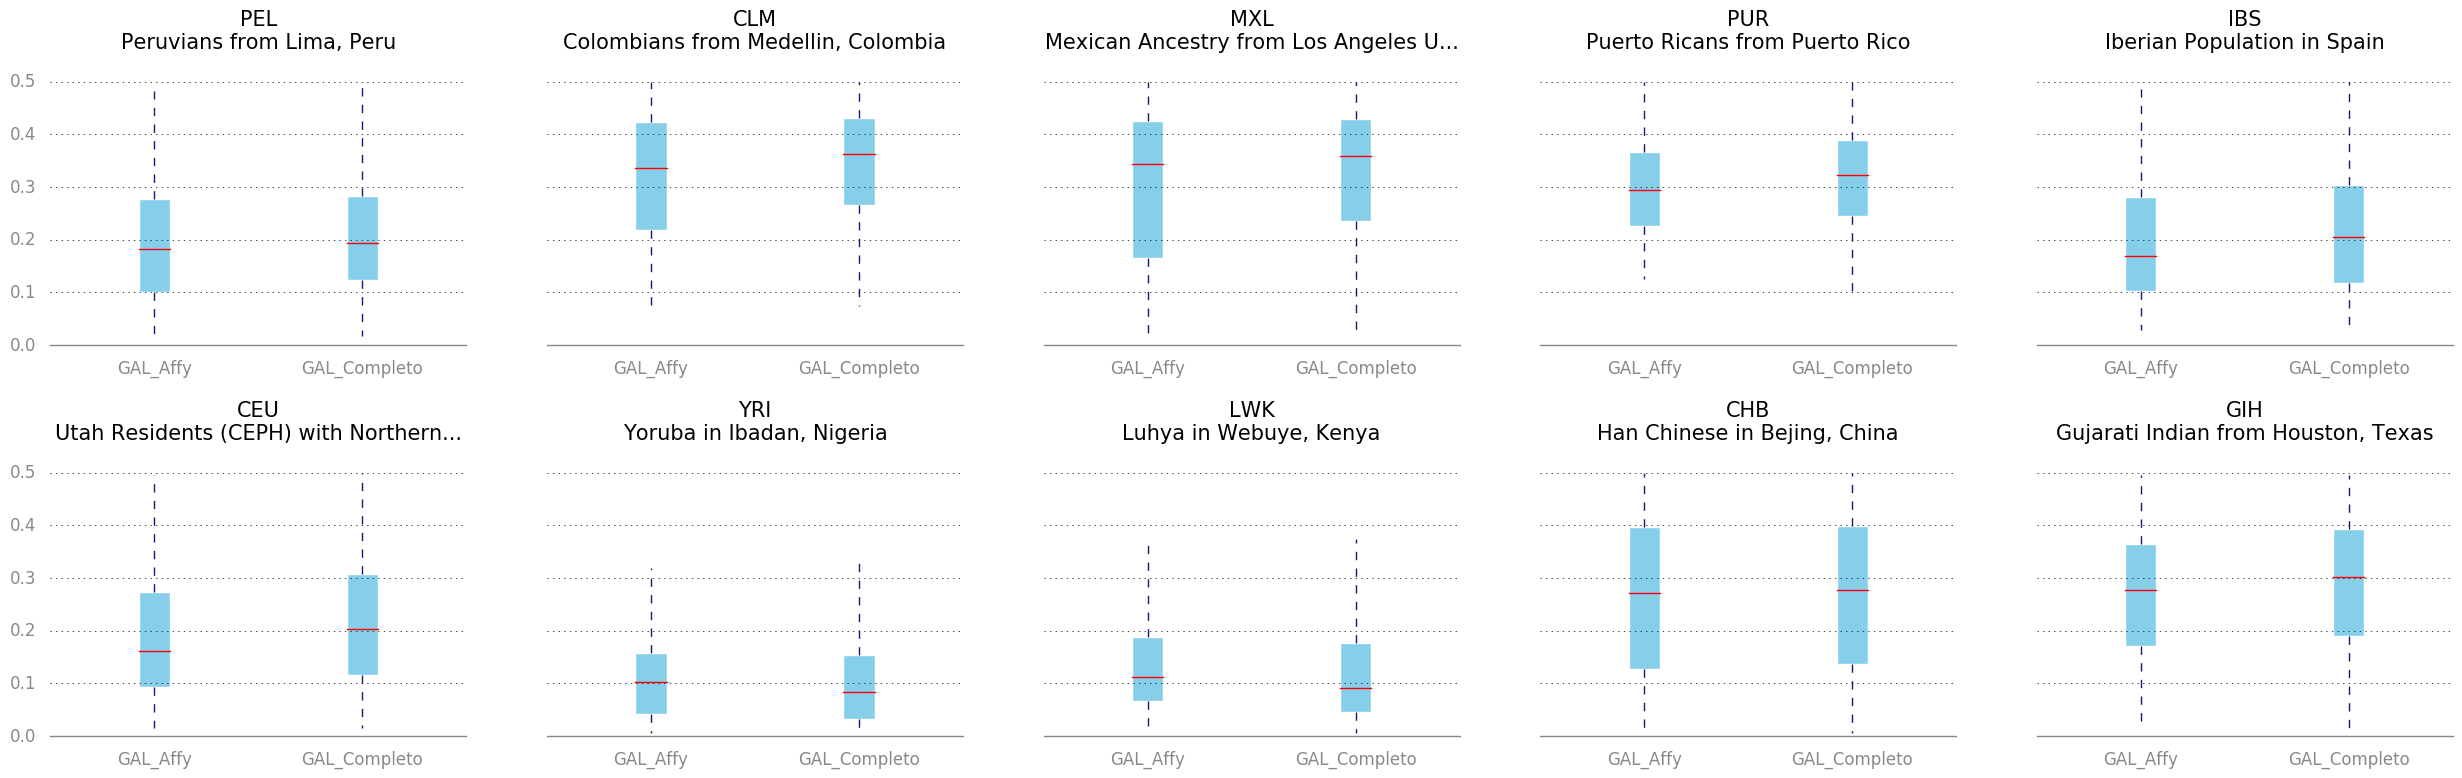

In [66]:
from helpers.text_helpers import trunc_text
from math import ceil

populations_to_plot = ["PEL", "CLM", "MXL", "PUR",
                       "IBS", "CEU", "YRI", "LWK",
                       "CHB", "GIH"]

plot_width = 5
plot_height = 4
ncols = 5
nrows = ceil(len(populations_to_plot) / ncols)

pops_matrix = np.array(populations_to_plot)
pops_matrix.resize(nrows, ncols)

figsize = (ncols * plot_width, nrows * plot_height)

fig, axes = plt.subplots(nrows, ncols, sharey="row", figsize=figsize)

for row in np.arange(nrows):
    for col in np.arange(ncols):
        population = pops_matrix[row][col]

        mafs_df = mafs["population"]
        ax = axes[row][col]
        
        if population == 0:  # Hack to deal with the np.array#resize extra values
            continue
            
        df = pd.DataFrame({"GAL_Affy": mafs_df["GAL_Affy"][population],
                           "GAL_Completo": mafs_df["GAL_Completo"][population]})
        pop_description = df_1000G_population_names.loc[population]['Population Description']
        ax.set_title(population + "\n" + trunc_text(pop_description, 35), y=1.1, fontsize=15)
        bp = df.boxplot(ax=ax, return_type='dict', patch_artist=True,
                        showcaps=False, showfliers=False)

        for patch in bp["boxes"]:
            patch.set_facecolor("SkyBlue")
            patch.set_edgecolor("white")
        for whiskers in bp["whiskers"]:
            whiskers.set_color("MidnightBlue")

        ax.set_ylim([0, 0.5])
        hide_spines_and_ticks(ax)
        ax.xaxis.grid()

plt.tight_layout()
plt.show()

In [67]:
mean_frequencies = lambda panel_name: mafs["population"][panel_name].mean()
std_frequencies = lambda panel_name: mafs["population"][panel_name].std()

In [76]:
import numpy as np
from collections import OrderedDict

df = pd.DataFrame(OrderedDict([
    ("GAL_Completo", mean_frequencies("GAL_Completo")),
    ("GAL_Affy", mean_frequencies("GAL_Affy")),
]))

df["Diferencia"] = (df["GAL_Completo"] - df["GAL_Affy"]).apply(abs)

df = df.applymap(lambda n: round(n, 2))
freq_diff = df.join(df_1000G_population_names[['Population Description', 'Super Population Code']]).fillna('')
freq_diff.sort_values(by='Diferencia', ascending=False, inplace=True)

freq_diff.iloc[:, :3]

,GAL_Completo,GAL_Affy,Diferencia
CLST,,,
STU,0.29,0.27,0.03
PJL,0.29,0.26,0.03
ITU,0.29,0.27,0.03
FIN,0.24,0.21,0.03
ACB,0.17,0.18,0.02
GIH,0.29,0.27,0.02
TSI,0.22,0.20,0.02
PUR,0.32,0.30,0.02
MXL,0.33,0.31,0.02


In [84]:
df = freq_diff.groupby("Super Population Code").mean()
df["Diferencia"] = abs(df["GAL_Completo"] - df["GAL_Affy"])
df.applymap(lambda x: round(x, 2))

,GAL_Completo,GAL_Affy,Diferencia
Super Population Code,,,
AFR,0.14,0.15,0.01
AMR,0.30,0.28,0.02
EAS,0.27,0.26,0.00
EUR,0.22,0.20,0.02
SAS,0.29,0.27,0.02
